In [12]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

def optimize_functions(functions, constraints, weights, with_bonus_intersections):
    x1, x2 = sp.symbols('x1 x2')

    def check_if_point_is_valid(point):
        for constraint in constraints:
            if constraint[1] == ">=":
                if constraint[0].subs(point) < 0:
                    return False
            elif constraint[1] == "<=":
                if constraint[0].subs(point) > 0:
                    return False
        return True

    # Find all intersections of the constraints
    bonus_intersections = [
        {sp.symbols('x1'): 10, sp.symbols('x2'): 10},
        {sp.symbols('x1'): 0, sp.symbols('x2'): 20},
        {sp.symbols('x1'): 10, sp.symbols('x2'): 0},
    ]

    xs_to_check = [20]

    for i in range(len(constraints)):
        for x in xs_to_check:
            x1_val = x
            x2_val = sp.solve(constraints[i][0].subs({x1: x}), x2)
            
            for val in x2_val:
                bonus_intersections.append({x1: x1_val, x2: val})
            
    intersections = []

    if with_bonus_intersections:
        intersections.extend(filter(lambda x: check_if_point_is_valid(x), bonus_intersections))

    for i in range(len(constraints)):
        for j in range(i + 1, len(constraints)):
            eq1 = constraints[i][0]
            eq2 = constraints[j][0]

            intersection = sp.solve([eq1, eq2], dict=True)

            for point in intersection:
                valid = check_if_point_is_valid(point)
                
                if valid:
                    intersections.append(point)
                else:
                    break

    # Plotting
    max_x1 = max([point[sp.symbols('x1')] for point in intersections])
    x1_vals = np.linspace(0, float(max_x1) + 5, 400)
    max_x2 = max([point[sp.symbols('x2')] for point in intersections])
    x2_vals = np.linspace(0, float(max_x2) + 5, 400)
    x1, x2 = np.meshgrid(x1_vals, x2_vals)

    plt.figure(figsize=(10, 8))

    # Plot constraints
    for constraint, sign in constraints:
        func = sp.lambdify((sp.symbols('x1'), sp.symbols('x2')), constraint, 'numpy')
        
        if sign == ">=":
            plt.contour(x1, x2, func(x1, x2), levels=[0], colors='r', linestyles='dashed')
        elif sign == "<=":
            plt.contour(x1, x2, func(x1, x2), levels=[0], colors='b', linestyles='dashed')
        
    # Plot intersections
    for point in intersections:
        plt.plot(point[sp.symbols('x1')], point[sp.symbols('x2')], 'ro')
        plt.text(point[sp.symbols('x1')], point[sp.symbols('x2')], f"({point[sp.symbols('x1')]}, {point[sp.symbols('x2')]})")

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Constraints and Intersections')
    plt.grid(True)
    plt.show()

    # Evaluate points for the given weights
    for w in weights: 
        print(f"Weight: {w}")
        points = []
        
        if len(intersections) == 0:
            print("No intersections found")
            continue
        
        for p in intersections:
            result_val = sum([w[i] * functions[i].subs(p) for i in range(len(functions))])
            
            # print(f"Point: {p}, Value: {result_val:.2f}")

            # for (i, f) in enumerate(functions):
            #     print(f"Function: {f}, Value: {w[i]:.2f} * {f.subs(p):.2f} = {w[i] * f.subs(p):.2f}")
            
            points.append((p, result_val))
            
        best_point = min(points, key=lambda x: x[1])
        print()
        print(f"Best point for weight {w}: {best_point[0]}, Value: {best_point[1]:.2f}")
        
        if best_point[0] in bonus_intersections:
            print("Probably suboptimal solution, and optimal solution is in the infinity")
        
        for (i, f) in enumerate(functions):
            print(f"Function: {f}, Value: {w[i]:.2f} * {f.subs(best_point[0]):.2f} = {w[i] * f.subs(best_point[0]):.2f}")
            
        print("---")

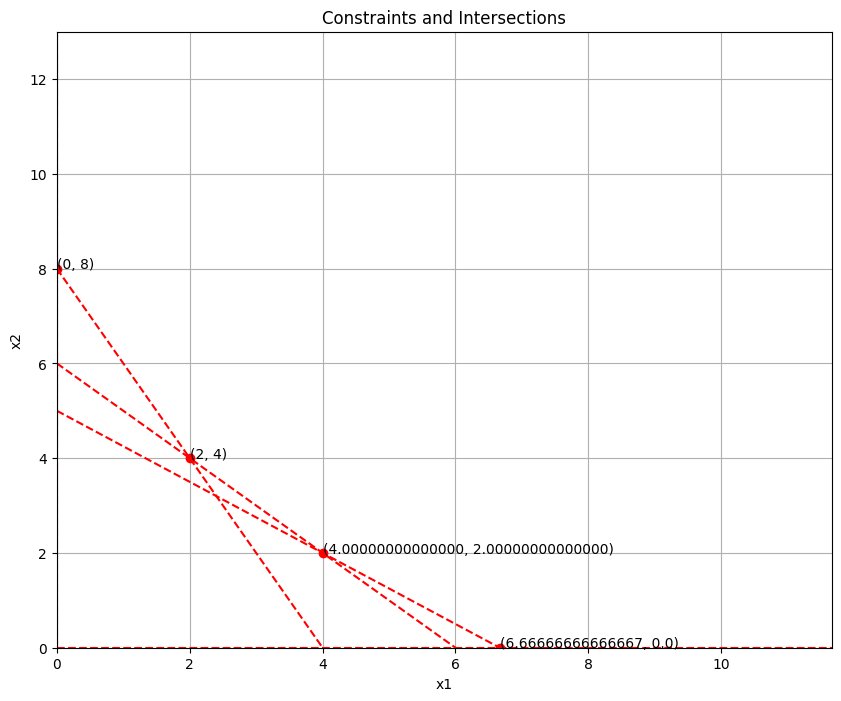

Weight: (0.5, 0.5)

Best point for weight (0.5, 0.5): {x1: 2, x2: 4}, Value: 9.00
Function: x1 + 2*x2, Value: 0.50 * 10.00 = 5.00
Function: 2*x1 + x2, Value: 0.50 * 8.00 = 4.00
---
Weight: (0.25, 0.75)

Best point for weight (0.25, 0.75): {x1: 2, x2: 4}, Value: 8.50
Function: x1 + 2*x2, Value: 0.25 * 10.00 = 2.50
Function: 2*x1 + x2, Value: 0.75 * 8.00 = 6.00
---
Weight: (0.7, 0.25)

Best point for weight (0.7, 0.25): {x1: 6.66666666666667, x2: 0.0}, Value: 8.00
Function: x1 + 2*x2, Value: 0.70 * 6.67 = 4.67
Function: 2*x1 + x2, Value: 0.25 * 13.33 = 3.33
---


In [13]:
functions = [
    sp.sympify("x1 + 2*x2"),
    sp.sympify("2*x1 + x2")
]

constraints = [
    [sp.sympify("x1 + x2 - 6"), ">="],
    [sp.sympify("2*x1 + x2 - 8"), ">="],
    [sp.sympify("0.75*x1 + x2 - 5"), ">="],
    [sp.sympify("x1"), ">="],
    [sp.sympify("x2"), ">="]
]

weights = [(0.5, 0.5), (0.25, 0.75), (0.7, 0.25)]

optimize_functions(functions, constraints, weights, with_bonus_intersections=False)

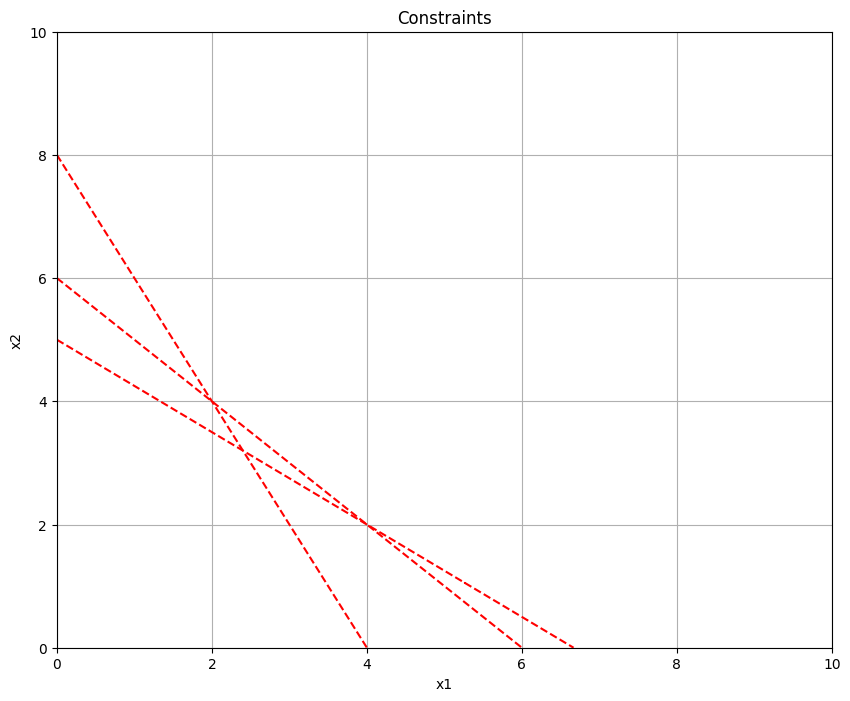

Rozwiązanie optymalne: x1 = 2.0, x2 = 4.0
Wartość funkcji celu: 8.5


In [19]:
from scipy.optimize import linprog
import matplotlib.pyplot as plt

def solve_weighted_multiobjective(objective_functions, constraints, weights):
    # Sprawdź, czy liczba funkcji celu jest zgodna z liczbą wag
    assert len(objective_functions) == len(weights), "Liczba funkcji celu musi być równa liczbie wag"
    
    # Zbuduj ważoną funkcję celu
    num_vars = len(objective_functions[0])
    weighted_objective = [0] * num_vars
    for i in range(num_vars):
        weighted_objective[i] = sum(weights[j] * objective_functions[j][i] for j in range(len(weights)))
    
    # Współczynniki ograniczeń (przekształcone na nierówności <=)
    A = []
    b = []
    for constraint in constraints:
        A.append([-coeff for coeff in constraint[:-1]])
        b.append(-constraint[-1])

    # Ograniczenia zmiennych (zakładamy, że wszystkie zmienne są nieujemne)
    x_bounds = [(0, None) for _ in range(num_vars)]

    # Rozwiąż problem
    result = linprog(weighted_objective, A_ub=A, b_ub=b, bounds=x_bounds, method='highs')

    x1_vals = np.linspace(0, 10, 400)
    x2_vals = np.linspace(0, 10, 400)
    x1, x2 = np.meshgrid(x1_vals, x2_vals)

    plt.figure(figsize=(10, 8))

    for constraint in constraints:
        a1, a2, b = constraint
        plt.contour(x1, x2, a1*x1 + a2*x2, levels=[b], colors='r', linestyles='dashed')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Constraints')
    plt.grid(True)
    plt.show()
    
    if result.success:
        return result.x, result.fun
    else:
        return None, None

# Definicje funkcji celu
objective_functions = [
    [1, 2],  # f1(x1, x2) = x1 + 2x2
    [2, 1]   # f2(x1, x2) = 2x1 + x2
]

# Ograniczenia (w formacie [a1, a2, b] dla nierówności a1*x1 + a2*x2 >= b)
constraints = [
    [1, 1, 6],     # x1 + x2 >= 6
    [2, 1, 8],     # 2x1 + x2 >= 8
    [0.75, 1, 5],  # 0.75x1 + x2 >= 5
]

#plot constrains



# Wagi
weights = [0.25, 0.75]

# Rozwiąż problem
solution, objective_value = solve_weighted_multiobjective(objective_functions, constraints, weights)

# Wyniki
if solution is not None:
    print(f"Rozwiązanie optymalne: x1 = {solution[0]:.1f}, x2 = {solution[1]:.1f}")
    print(f"Wartość funkcji celu: {objective_value:.1f}")
else:
    print("Nie znaleziono rozwiązania optymalnego.")
